In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

2024-05-22 22:28:37.734076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 22:28:40.245066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Cargar el dataset desde el archivo CSV
path = "dataset/divvy_daily.csv"
df = pd.read_csv(path)

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.set_index('date')
rnn_df = df.drop(columns=['temperature', 'weather'])

In [4]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(rnn_df) * 0.8)
test_size = len(rnn_df) - train_size
train_data, test_data = rnn_df.iloc[0:train_size], rnn_df.iloc[train_size:len(rnn_df)]

In [5]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [6]:
# Crear el conjunto de datos para entrenamiento
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

In [8]:
# Reshape de los datos para [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Construir y entrenar el modelo RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(SimpleRNN(50, return_sequences=False))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

/home/juanperdomo/forecasting-divvy-bike-rides/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0845
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0133
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0105
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0104
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0127
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102
Epoch 15/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

In [10]:
# Hacer predicciones con RNN
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [11]:
# Invertir la escala de las predicciones
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

In [12]:
# Calcular MAPE para el conjunto de prueba
mape_rnn = mean_absolute_percentage_error(y_test_true, test_predict_rnn)
print(f'MAPE RNN: {mape_rnn:.4f}')

MAPE RNN: 0.3350


In [13]:
# Visualizar los resultados
plt.figure(figsize=(14, 5))


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

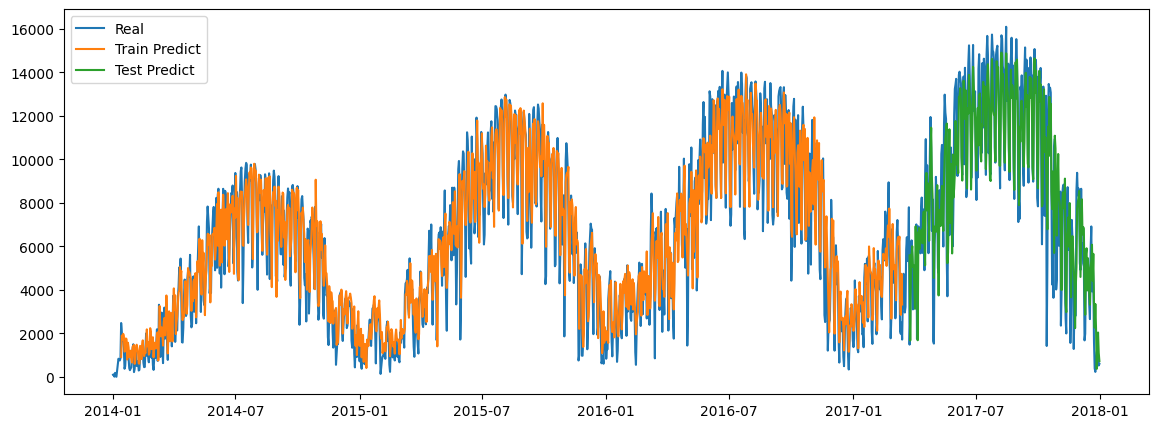

In [15]:
# Visualizar los resultados
plt.figure(figsize=(14, 5))

# Ajustar los índices para los valores reales y las predicciones
train_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict_rnn) + time_step, :] = train_predict_rnn

test_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_rnn) + (time_step * 2):len(rnn_df), :] = test_predict_rnn

plt.plot(rnn_df.index, scaler.inverse_transform(np.concatenate((train_scaled, test_scaled), axis=0)), label='Real')
plt.plot(rnn_df.index, train_predict_plot, label='Train Predict')
plt.plot(rnn_df.index, test_predict_plot, label='Test Predict')
plt.legend()
plt.show()